<a href="https://colab.research.google.com/github/nurcse/MachineLearning/blob/master/Sakura.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
uploaded = files.upload()


Saving sakura.csv to sakura.csv


In [0]:

import numpy as np

import pandas as pd
import io

import matplotlib.pyplot as plt

from sklearn.metrics import r2_score


In [4]:
""" To load uploaded data into DataFrame
    make sure the filename matches the name of the uploaded file
"""

all_data_df = pd.read_csv(io.BytesIO(uploaded['sakura.csv']))
#print(test_df.head())
print('Columns :', all_data_df.columns)

print('number of columns :', len(all_data_df.columns), '\nnumber of rows :', len(all_data_df))

#all_data_df.head()

Columns : Index(['serial', 'year', 'month', 'day', 'local pressure', 'sea pressure',
       'total preci', 'hr1 preci', 'min10 preci', 'avg temp', 'max temp',
       'min temp', 'avg humid', 'min humid', 'sun hours', 'bloom'],
      dtype='object')
number of columns : 16 
number of rows : 20544


`a_df = df.loc[df['A']=='foo']` to get a DF depends on a single value conditon on a column

---


`b_df = df.loc[~df['column_name'].isin(some_values)]` to get a DF which doesn't match the condition, here condition is a List of values


In [5]:
"""
    Train DF and Test DF splitting
"""

test_df = all_data_df.loc[all_data_df.year.isin([1966, 1971, 1985, 1994, 2008])] # it returns a DataFrame on matched condition
#print(test_df.head())


# Get Train_DF
train_df = all_data_df.loc[~all_data_df.year.isin([1966, 1971, 1985, 1994, 2008])] # returns a DF which rows don't match these conditions
#print(train_df.head())
train_df.head()

,serial,year,month,day,local pressure,sea pressure,total preci,hr1 preci,min10 preci,avg temp,max temp,min temp,avg humid,min humid,sun hours,bloom
0,0,1961,1,1,1011.7,1012.4,0.0,0.0,0.0,2.1,7.9,-3.9,41,15,8.6,0
1,1,1961,1,2,1020.2,1021.0,0.0,0.0,0.0,1.5,9.2,-3.3,51,26,8.7,0
2,2,1961,1,3,1021.3,1022.1,0.1,0.8,0.0,2.5,7.3,-2.4,58,37,5.4,0
3,3,1961,1,4,1004.6,1005.3,20.2,13.9,3.2,4.7,11.5,0.6,60,38,1.0,0
4,4,1961,1,5,1016.3,1017.0,0.0,0.0,0.0,3.8,7.7,1.4,33,19,8.3,0


In [6]:
# checking if sum of  trainDF and testDF have same rows equal to allDF
print(len(train_df))
print('sum of len:', len(train_df)+len(test_df))

18718
sum of len: 20544


In [7]:
train_years = np.unique(train_df.year)
train_years

#true_bloom_days_eYear = train_df.loc[train_df.bloom == 1] # this returns a DF on which rows match the condition
#true_bloom_days_eYear

array([1961, 1962, 1963, 1964, 1965, 1967, 1968, 1969, 1970, 1972, 1973,
       1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984,
       1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1995, 1996, 1997,
       1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2009,
       2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017])

###Problem 1-1:
From here-on, we refer to the bloom-date in a given year $j$ as $BD_{j}$. For each year in the training data, calculate the accumulated daily maximum temperature from February 1st to the actual bloom-date $BD_{j}$, and plot this accumulated value over the training period. Then, average this accumulated value as $T_{mean}$, and verify whether we should use 600$^\circ$C as a rule for Tokyo.

For getting index of a **row** based on a condition from a DF : `index = int(df[df['A']==5].index[0])`

In [0]:

feb_1_indexes = []
actual_bloomDay_indexes = []
c_sum_of_maxTemps = []
for i in range(len(train_years)):
  #print(train_years[i])
  
  feb_1_indexes.append(int(train_df[(train_df.month==2) & (train_df.day==1) & (train_df.year==train_years[i])].index[0]))
  
  actual_bloomDay_indexes.append(int(train_df[(train_df.bloom==1) & (train_df.year==train_years[i])].index[0]))
  
  c_sum_of_maxTemps.append(train_df.loc[feb_1_indexes[i]:actual_bloomDay_indexes[i], 'max temp'].sum(axis=0))
  
  print(train_years[i],'Feb 1 index :', feb_1_indexes[i], '\tbloom index :', actual_bloomDay_indexes[i], '\tcumulative sum of max temp. :', c_sum_of_maxTemps[i])
Tmean = np.mean(c_sum_of_maxTemps)
print('Tmean of cumulative temperature over the training years :', Tmean)


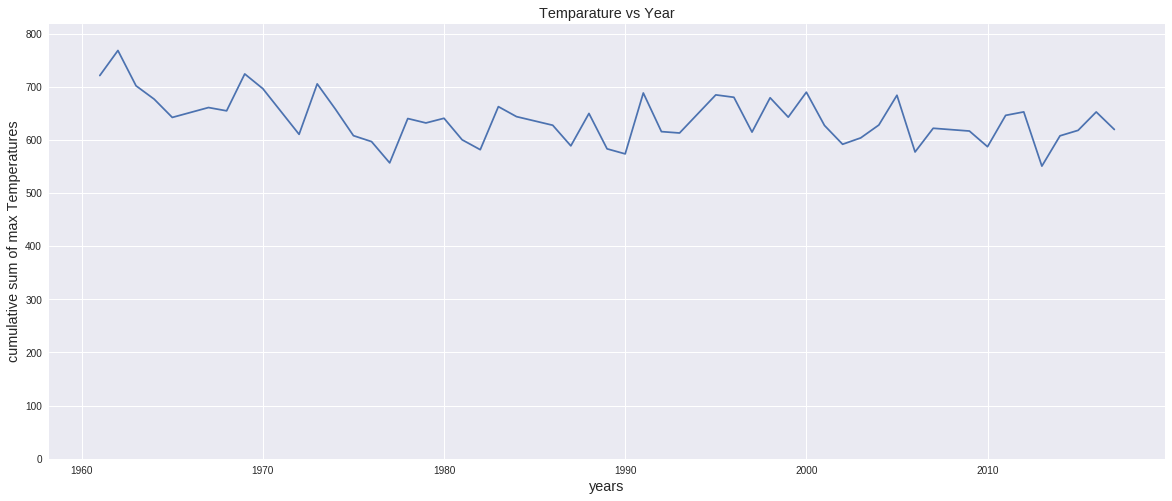

In [118]:

plt.plot(train_years, c_sum_of_maxTemps)
#plt.plot(train_years, c_sum_of_maxTemps, 'o', linestyle=':' ) #color='r'

plt.xlabel('years', fontsize='large')
plt.ylabel('cumulative sum of max Temperatures', fontsize='large')

plt.title("Temparature vs Year", fontsize='large')

#plt.xlim(0, len(loss_list) + 10)
plt.ylim(0, np.max(c_sum_of_maxTemps)+50)

plt.rcParams['figure.figsize'] = [20, 8]
plt.show()


### Problem 1-2: 

Use the average accumulated value $T_{mean}$ calculated in 1-1 to predict $BD_{j}$ for each test year, and show the error from the actual $BD_{j}$. Compare to the prediction results when 600$^\circ$C is used a threshold value, and evaluate both models using the coefficient of determination ($R^2$ score).

In [12]:

test_years = np.unique(test_df.year)
test_years


array([1966, 1971, 1985, 1994, 2008])

In [0]:

true_bloom_days_in_test_years = test_df.loc[test_df.bloom == 1]
true_bloom_days_in_test_years


In [13]:
feb_1_indexes_test = []
actual_bloomDay_indexes_test = []
c_sum_of_maxTemps_test = []
predicted_sum_of_maxTemps = []

number_of_days_Tmean = []
number_of_days_actual = []
number_of_days_600 = []

print('Tmean :', Tmean,'\n')

for i in range(len(test_years)):
  #print(train_years[i])
  
  feb_1_indexes_test.append(int(test_df[(test_df.month==2) & (test_df.day==1) & (test_df.year==test_years[i])].index[0]))
  
  actual_bloomDay_indexes_test.append(int(test_df[(test_df.bloom==1) & (test_df.year==test_years[i])].index[0]))
  
  c_sum_of_maxTemps_test.append(test_df.loc[feb_1_indexes_test[i]:actual_bloomDay_indexes_test[i], 'max temp'].sum(axis=0))
  
  predicted_temp_sum = 0
  index = feb_1_indexes_test[i]
  numberOfDays = 0
  flag = True
  
  while(predicted_temp_sum < Tmean):
    predicted_temp_sum += test_df.loc[index, 'max temp']
    index += 1
    numberOfDays += 1
    
    if(predicted_temp_sum >= 600 and flag):
      number_of_days_600.append(numberOfDays)
      flag = False
      
  number_of_days_Tmean.append(numberOfDays)
  number_of_days_actual.append((actual_bloomDay_indexes_test[i] - feb_1_indexes_test[i] + 1))
  predicted_sum_of_maxTemps.append(predicted_temp_sum)
  
  print(test_years[i],'Feb 1 index :', feb_1_indexes_test[i], '\tbloom index :', actual_bloomDay_indexes_test[i], '\tactual cumulative sum :', c_sum_of_maxTemps_test[i]
       ,'\tcumulative sum of prediction :', predicted_sum_of_maxTemps[i])
  print('==> actually required days :', number_of_days_actual[i], '\tTmean used predicted required days :', number_of_days_Tmean[i], '\t600* used predicted required days :'
        , number_of_days_600[i],'\n')
  
print('Tmean of cumulative temperature(feb1 - actual bloom day) over the test years :', np.mean(c_sum_of_maxTemps_test))
  

Tmean : 638.3557692307693 

1966 Feb 1 index : 1857 	bloom index : 1904 	actual cumulative sum : 607.6 	cumulative sum of prediction : 649.6999999999998
==> actually required days : 48 	Tmean used predicted required days : 51 	600* used predicted required days : 48 

1971 Feb 1 index : 3683 	bloom index : 3740 	actual cumulative sum : 663.4000000000001 	cumulative sum of prediction : 644.8000000000001
==> actually required days : 58 	Tmean used predicted required days : 57 	600* used predicted required days : 55 

1985 Feb 1 index : 8797 	bloom index : 8858 	actual cumulative sum : 677.8000000000002 	cumulative sum of prediction : 644.6
==> actually required days : 62 	Tmean used predicted required days : 60 	600* used predicted required days : 57 

1994 Feb 1 index : 12084 	bloom index : 12142 	actual cumulative sum : 656.6 	cumulative sum of prediction : 656.5999999999999
==> actually required days : 59 	Tmean used predicted required days : 59 	600* used predicted required days : 56 

RMSE for Tmean : 2.1447610589527217
RMSE for 600 Degree C : 2.9664793948382653

R^2 Score for Tmean : 0.8323615160349854
R^2 Score for 600 Degree C : 0.6793002915451896


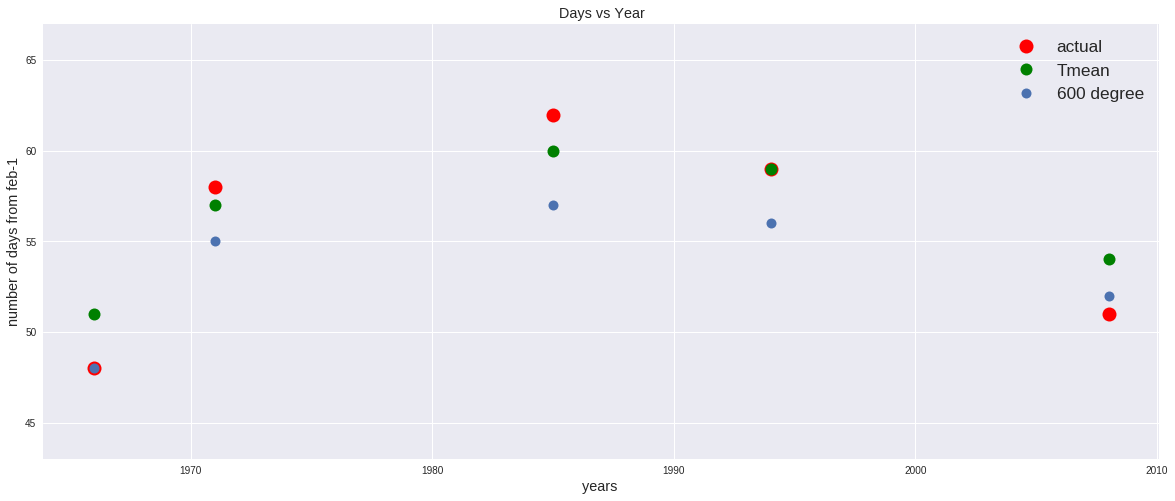

In [119]:

rmse_Tmean = np.sqrt(np.mean((np.array(number_of_days_actual) - np.array(number_of_days_Tmean))**2))
print('RMSE for Tmean :', rmse_Tmean)

rmse_600 = np.sqrt(np.mean((np.array(number_of_days_actual) - np.array(number_of_days_600))**2))
print('RMSE for 600 Degree C :', rmse_600)

print('\nR^2 Score for Tmean :', r2_score(number_of_days_actual, number_of_days_Tmean))
print('R^2 Score for 600 Degree C :', r2_score(number_of_days_actual, number_of_days_600))

plt.plot(test_years, number_of_days_actual, 'o', markersize=14, color='r')
plt.plot(test_years, number_of_days_Tmean, 'o', markersize=12, color='g')
plt.plot(test_years, number_of_days_600, 'o', markersize=10)
plt.legend(('actual', 'Tmean', '600 degree'), loc='upper right', shadow=True, fontsize='x-large')

plt.xlabel('years ', fontsize='large')
plt.ylabel('number of days from feb-1', fontsize='large')
plt.title("Days vs Year", fontsize='large')
#plt.xlim(0, len(loss_list) + 10)
plt.ylim(np.min(number_of_days_actual)-5, np.max(number_of_days_actual)+5)
plt.rcParams['figure.figsize'] = [20, 8]
plt.show()


### Evaluation (Comment on R^2 score)
We saw that RMSE score is greater when we used 600 degree C. as threshold than Tmean. 
<br>
And also R^2 score is smaller when we used 600 degree C. as threshold than Tmean. So we can say that **Tmean is a better model than 600 degree C**. model.

### Problem 2-1:
According to Hayashi et al. (2012), the day on which the sakura will awaken from their hibernation phase, $D_{j}$, for a given location, can be approximated by the following equation:
<br> <br>
$$
D_{j} = 136.75 - 7.689 \phi + 0.133 \phi^{2} -1.307\ln L + 0.144T_{F} + 0.285T_{F}^2
$$ <br>

where $\phi$ is the latitude [°N], $L$ is the distance from the nearest coastline [km], and $T_{F}$ is that location's average temperature [°C] over the first 3 months of a given year. In the case of Tokyo, $\phi = 35°40'$ and $L=4\rm{km}$.

Find the $D_{j}$ value for every year $j$ from 1961 to 2017 (including the test years), and plot this value on a graph. 

(In Problem 1, we had assumed a $D_j$ of February 1st.)

In [22]:

all_years = np.unique(all_data_df.year)

PHI_TOKYO = 35 + (40/60)
print(PHI_TOKYO)
L_TOKYO = 4 # L = L is the distance from the nearest coastline

jan_1_indexes_years = []
jan_1_indexes_years_dic = {}

mar_31_indexes_years = []
avg_temp_first3months_each_years = []

Dj_each_years = []
Dj_train_years = []
Dj_test_years = []

for i in range(len(all_years)):
  jan_1_indexes_years.append(int(all_data_df[(all_data_df.month==1) & (all_data_df.day==1) & (all_data_df.year==all_years[i])].index[0]))
  jan_1_indexes_years_dic[all_years[i]] = int(all_data_df[(all_data_df.month==1) & (all_data_df.day==1) & (all_data_df.year==all_years[i])].index[0])
  
  mar_31_indexes_years.append(int(all_data_df[(all_data_df.month==3) & (all_data_df.day==31) & (all_data_df.year==all_years[i])].index[0]))
  
  avg_temp_first3months_each_years.append(all_data_df.loc[jan_1_indexes_years[i] : mar_31_indexes_years[i], 'avg temp'].mean(axis=0))
  
  # Dj = 136.75 − 7.689ϕ + 0.133ϕ2 − 1.307lnL + 0.144TF + 0.285T2F
  Dj_each_years.append(136.75 - (7.689*PHI_TOKYO) + (0.133*PHI_TOKYO**2) - (1.307*np.log(L_TOKYO)) + (0.144*avg_temp_first3months_each_years[i]) + 
                      (0.285*avg_temp_first3months_each_years[i]**2))
  
  if(all_years[i] in test_years):
    Dj_test_years.append(Dj_each_years[i])
  else:
    Dj_train_years.append(Dj_each_years[i])


print('avg. temp of first 3 months :', avg_temp_first3months_each_years)
print('Dj value of all years :', Dj_each_years)


35.666666666666664
avg. temp of first 3 months : [5.471111111111112, 6.254444444444444, 5.2155555555555555, 5.752747252747253, 5.354444444444446, 7.13888888888889, 6.334444444444444, 6.740659340659338, 6.438888888888887, 5.335555555555556, 6.445555555555556, 7.164835164835163, 6.985555555555558, 5.601111111111112, 5.90888888888889, 7.037362637362637, 5.918888888888888, 6.23, 8.307777777777776, 6.364835164835164, 6.262222222222222, 7.082222222222221, 6.983333333333333, 4.246153846153847, 6.110000000000001, 5.548888888888889, 7.328888888888888, 7.035164835164836, 8.413333333333336, 7.797777777777776, 7.487777777777776, 7.810989010989011, 7.519999999999998, 6.727777777777776, 7.2411111111111115, 7.093406593406592, 8.153333333333332, 7.514444444444448, 7.834444444444443, 7.684615384615386, 7.132222222222222, 9.234444444444446, 6.87111111111111, 8.218681318681316, 7.112222222222224, 7.205555555555556, 9.05, 7.4021978021978025, 8.193333333333335, 7.574444444444443, 6.704444444444444, 6.37692

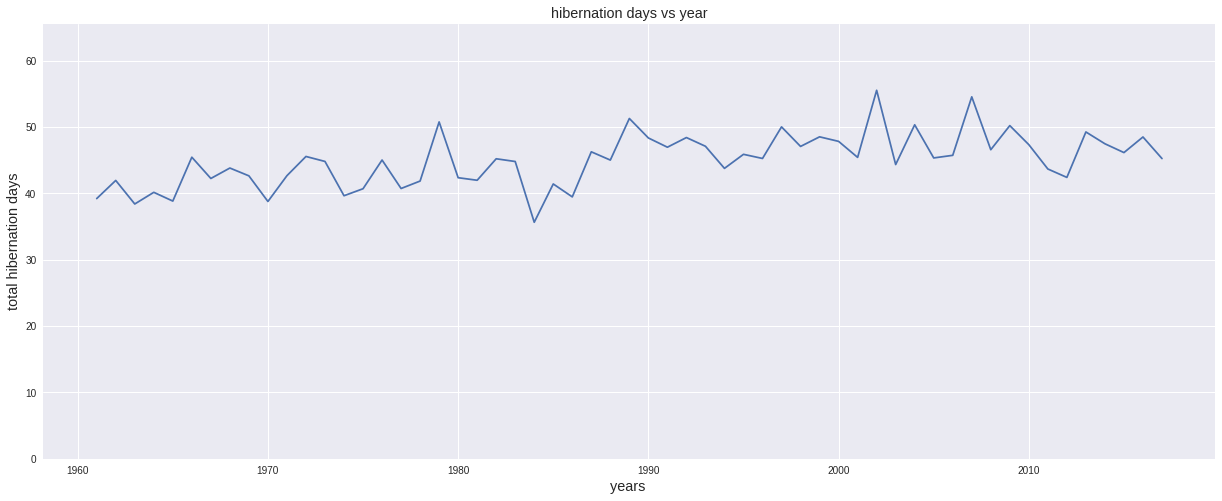

In [105]:

plt.plot(all_years, Dj_each_years)

plt.xlabel('years ', fontsize='large')
plt.ylabel('total hibernation days', fontsize='large')

plt.title("hibernation days vs year", fontsize='large')
#plt.xlim(0, len(loss_list) + 10)
plt.ylim(0, np.max(Dj_each_years)+10)

plt.rcParams['figure.figsize'] = [20, 8]
plt.show()


### Problem 2-2:
Calcluate $DTS_j$ for each year $j$ in the training set for discrete values of $E_{a}$, varying from 5 to 40kcal ($E_{a} = 5, 6, 7, \cdots, 40 \,\rm{kcal}$), and plot this $DTS_j$ against $E_{a}$. Also calculate the average of $DTS_{j}$ over the training period, and indicate it on the plot as $DTS_{mean}$. Pay attention to the units of **every parameter** ($T_{i,j}$, $E_{a}$, ...) in the equation for $t_{s}$. 

In [26]:

Dj_train_years_indexes = []
for i in range(len(train_years)):
  Dj_train_years[i] = round(Dj_train_years[i])
  Dj_train_years_indexes.append( int(jan_1_indexes_years_dic[train_years[i]] + Dj_train_years[i] - 1) )
  
print(Dj_train_years_indexes)

[38, 406, 767, 1134, 1499, 2232, 2599, 2964, 3325, 4062, 4427, 4787, 5153, 5522, 5884, 6250, 6624, 6980, 7346, 7714, 8079, 8435, 9169, 9541, 9905, 10277, 10639, 11003, 11369, 11734, 12463, 12827, 13198, 13560, 13927, 14291, 14654, 15030, 15383, 15754, 16115, 16481, 16855, 17581, 17943, 18305, 18668, 19041, 19404, 19768, 20135, 20498]


In [27]:
DTSj_each_Ea_dic = {}
DTSj_mean_train = []

Ts = 290.15
R = 8.314

for Ea in range(5, 41):
  DTSj_each_year = []
  for i in range(len(train_years)):
    ts = 0
    for j in range(Dj_train_years_indexes[i] , actual_bloomDay_indexes[i]+1):
      Tij = train_df.loc[j, 'avg temp'] + 273.15
      ts += np.exp((Ea*4.184*1000*(Tij-Ts)) / (R * Tij * Ts))
    DTSj_each_year.append(ts)
  DTSj_mean_train.append(np.mean(DTSj_each_year))
  DTSj_each_Ea_dic[Ea] = DTSj_each_year
  
DTSj_each_Ea_dic
print('DTSj_mean over train for every Ea :', DTSj_mean_train)

DTSj_mean over train for every Ea : [31.89948520675808, 30.200755693591102, 28.60505732345086, 27.105658587998736, 25.69629252980513, 24.37112325700012, 23.124714961251488, 21.952003245917986, 20.848268586550777, 19.809111759994924, 18.830431091278292, 17.908401379362793, 17.03945437375904, 16.220260684050405, 15.447713013607816, 14.718910617270657, 14.031144890580995, 13.381886005346226, 12.768770512917822, 12.189589842660617, 11.642279628688973, 11.12490980310392, 10.635675398714552, 10.172888008601044, 9.734967853905468, 9.320436414948857, 8.927909584193506, 8.556091302722063, 8.203767644811283, 7.869801317857723, 7.553126547383671, 7.252744319130586, 6.967717952349905, 6.697168980340852, 6.44027331607519, 6.196257682401297]


Ea : [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]


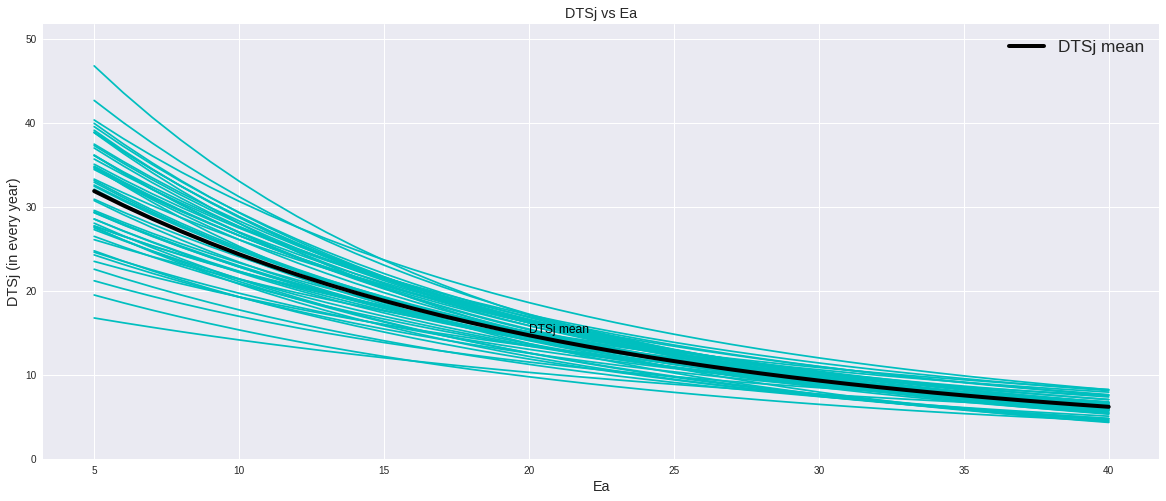

In [122]:

DTSj_year_Ea = []
Ea = [i for i in range(5,41)]
print('Ea :', Ea)

for i in range(len(train_years)):
  DTSj_year = []
  for val in Ea:
    DTSj_year.append(DTSj_each_Ea_dic[val][i])
  DTSj_year_Ea.append(DTSj_year)
  
  plt.plot(Ea, DTSj_year, color='c')
#print(DTSj_year_Ea) 

plt.plot(Ea, DTSj_mean_train, color='k', label='DTSj mean', linewidth=4)

plt.legend(loc='best', shadow=True, fontsize='x-large')
plt.text(20, 15, 'DTSj mean', color='k')

plt.xlabel('Ea', fontsize='large')
plt.ylabel('DTSj (in every year)', fontsize='large')

plt.title("DTSj vs Ea", fontsize='large')
#plt.xlim(0, len(loss_list) + 10)
plt.ylim(0, np.max(DTSj_year_Ea)+5)

plt.rcParams['figure.figsize'] = [20, 8]
plt.show()


### Problem 2-3:
Using the same $E_{a}$ values and calculated $DTS_{mean}$ from 2-2, predict the bloom date $BD_{j}$ for each of the training years. Find the mean squared error relative to the actual $BD$ and plot it against $E_{a}$. Find the optimal $E_{a}^{*}$ that minimizes that error on the training data.

In [0]:

R2_scores_train = []
MSE_scores_train = []

Ea = [i for i in range(5,41)]
Ts = 290.15
R = 8.314

for j in range(len(Ea)):
  number_of_days_DTSmean_train = []
  number_of_days_actual_train = []
  print('values for when Ea :', Ea[j], '\tDTSmean :', DTSj_mean_train[j])
  
  for i in range(len(train_years)):
    ts_train = 0
    number_of_days = 0
    Dj_train_index = Dj_train_years_indexes[i]

    while(ts_train <= DTSj_mean_train[j]):
      Tij_train = train_df.loc[Dj_train_index, 'avg temp'] + 273.15
      ts_train += np.exp((Ea[j]*4.184*1000*(Tij_train - Ts)) / (R * Tij_train * Ts))
      number_of_days += 1
      Dj_train_index += 1
      if(Dj_train_index >= 20544):
        break
      
    number_of_days_DTSmean_train.append(number_of_days)
    number_of_days_actual_train.append((actual_bloomDay_indexes[i] - Dj_train_years_indexes[i] + 1))
    
    print('==> actually required days :', number_of_days_actual_train[i], '\tpredicted DTSmean required days :', number_of_days_DTSmean_train[i])
    
  mse_DTSmean = np.mean((np.array(number_of_days_actual_train) - np.array(number_of_days_DTSmean_train))**2)
  MSE_scores_train.append(mse_DTSmean)
  
  R2_scores_train.append(r2_score(number_of_days_actual_train, number_of_days_DTSmean_train))
  
  print('for Ea :', Ea[j], 'MSE is :', mse_DTSmean, '\tR^2 :', R2_scores_train[j])


In [83]:

print('index of minimum MSE error :', np.argmin(MSE_scores_train))
print('Training minimum MSE error :', MSE_scores_train[np.argmin(MSE_scores_train)], '\t Training r2 score(when error lowest) :', R2_scores_train[np.argmin(MSE_scores_train)])
print('DTSmean for which MSE was lowest :', DTSj_mean_train[np.argmin(MSE_scores_train)])
print('Optimal E* :', Ea[np.argmin(MSE_scores_train)])


index of minimum MSE error : 23
Training minimum MSE error : 9.365384615384615 	 Training r2 score(when error lowest) : 0.8933110889228734
DTSmean for which MSE was lowest : 10.172888008601044
Optimal E* : 28


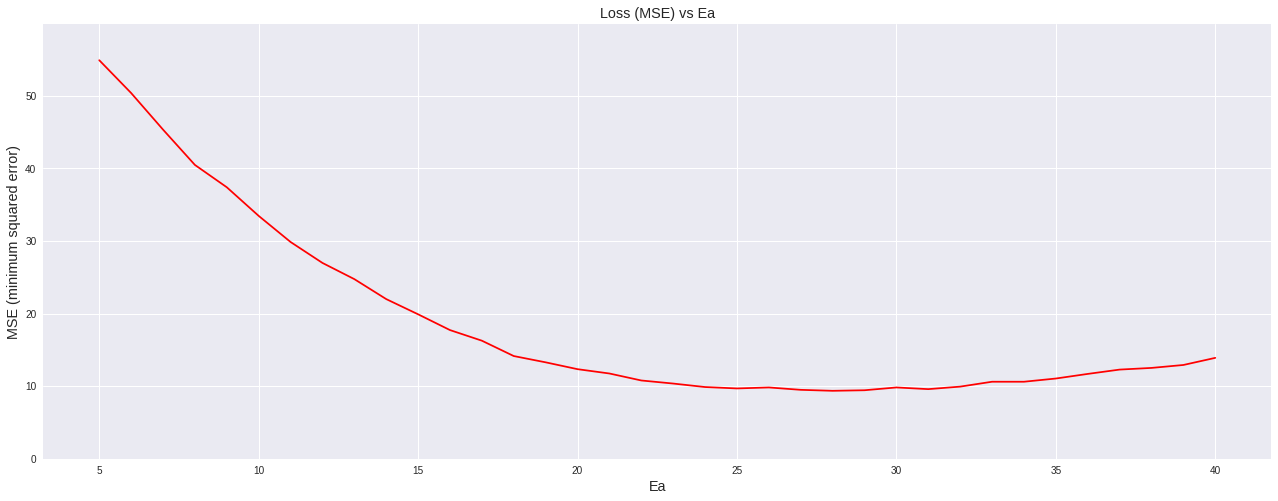

In [132]:
plt.plot(Ea, MSE_scores_train, color='r')

plt.xlabel('Ea', fontsize='large')
plt.ylabel('MSE (minimum squared error)', fontsize='large')

plt.title("Loss (MSE) vs Ea", fontsize='large')
#plt.xlim(0, len(loss_list) + 10)
plt.ylim(0, np.max(MSE_scores_train)+5)

plt.rcParams['figure.figsize'] = [22, 9]
plt.show()

### Problem 2-4:

Using the $D_j$ dates from problem 2-1, the average $DTS_{mean}$ from 2-2, and the best-fit $E_{a}^{*}$ from 2-3, predict the bloom-dates $BD_j$ for the years in the test set. Determine the error between your predicted $BD_j$ values and the actual values, and evaluate this model using the coefficient of determination ($R^2$ score).

In [95]:

Dj_test_years_indexes = []
for i in range(len(test_years)):
  Dj_test_years[i] = round(Dj_test_years[i])
  Dj_test_years_indexes.append( int(jan_1_indexes_years_dic[test_years[i]] + Dj_test_years[i] - 1) )

Dj_test_years_indexes

[1870, 3694, 8806, 12096, 17212]

In [96]:

Ea_star = Ea[np.argmin(MSE_scores_train)]
Ts = 290.15
R = 8.314

number_of_days_DTSmean_test = []
number_of_days_actual_test = []

for i in range(len(test_years)):
  ts_test = 0
  number_of_days = 0
  Dj_test_index = Dj_test_years_indexes[i]

  while(ts_test <= DTSj_mean_train[np.argmin(MSE_scores_train)]):
    Tij_test = test_df.loc[Dj_test_index, 'avg temp'] + 273.15
    ts_test += np.exp((Ea_star*4.184*1000*(Tij_test - Ts)) / (R * Tij_test * Ts))
    number_of_days += 1
    Dj_test_index += 1
    
  number_of_days_DTSmean_test.append(number_of_days)
  number_of_days_actual_test.append((actual_bloomDay_indexes_test[i] - Dj_test_years_indexes[i] + 1))

  print('==> actually required days :', number_of_days_actual_test[i], '\tpredicted DTSmean required days :', number_of_days_DTSmean_test[i])
  
R2_scores_test = r2_score(number_of_days_actual_test, number_of_days_DTSmean_test)
  
print('for Ea :', Ea_star, '\tR^2 :', R2_scores_train[j])


==> actually required days : 35 	predicted DTSmean required days : 35
==> actually required days : 47 	predicted DTSmean required days : 46
==> actually required days : 53 	predicted DTSmean required days : 51
==> actually required days : 47 	predicted DTSmean required days : 48
==> actually required days : 36 	predicted DTSmean required days : 37
for Ea : 28 	R^2 : 0.8416096864296457


### Problem 3-1: 

Build a neural network and train it on the data from the training years. Use this model to predict the bloom-dates for each year in the test set. Evaluate the error between predicted dates and actual dates using the coefficient of determination (R2 score). Only use the weather data given in `tokyo.csv` and the sakura data acquired in problem 0-1.</br>
You may use whichever framework or strategy that you like to construct the network. 

In [0]:
test_df.loc[Dj_test_years_indexes]
test_df.loc[actual_bloomDay_indexes_test]

,serial,year,month,day,local pressure,sea pressure,total preci,hr1 preci,min10 preci,avg temp,max temp,min temp,avg humid,min humid,sun hours,bloom
1904,1904,1966,3,20,995.7,1000.0,0.0,0.0,0.0,7.0,12.5,3.1,42,26,7.8,1
3740,3740,1971,3,30,1009.8,1014.1,9.0,2.5,0.5,14.7,18.6,10.5,87,66,0.0,1
8858,8858,1985,4,3,1022.9,1027.2,0.0,0.0,0.0,15.4,18.5,12.2,58,39,9.6,1
12142,12142,1994,3,31,1012.9,1017.2,0.0,0.0,0.0,13.1,18.7,7.9,45,20,10.8,1
17247,17247,2008,3,22,1014.0,1018.4,0.0,0.0,0.0,11.9,17.7,7.1,37,19,11.2,1


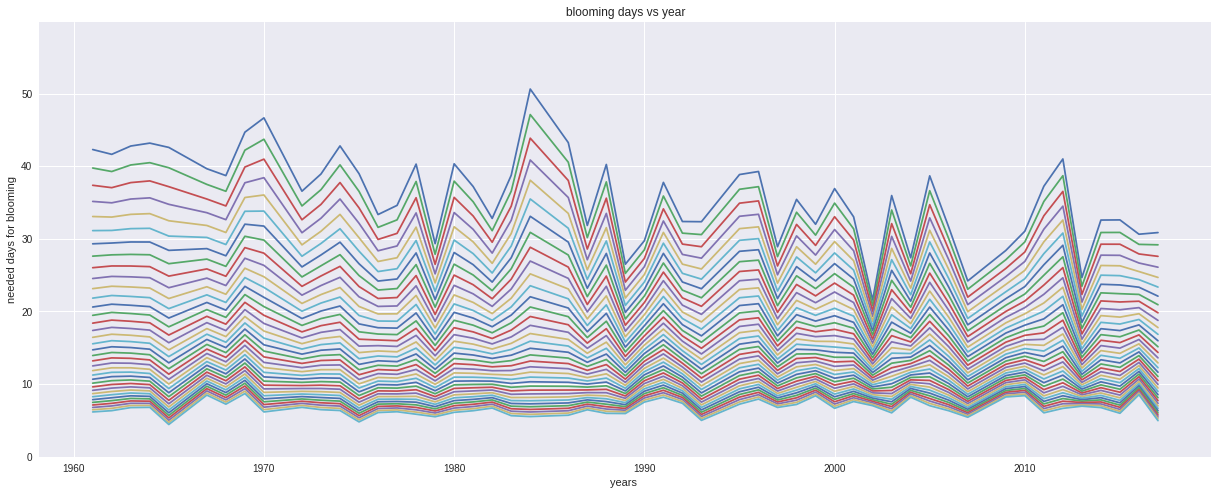

In [0]:
for key in DTSj_each_Ea_dic:
  #print(key)
  plt.plot(train_years, DTSj_each_Ea_dic[key])
plt.xlabel('years ')
plt.ylabel('needed days for blooming')
plt.title("blooming days vs year")
#plt.xlim(0, len(loss_list) + 10)
plt.ylim(0, np.max(Dj_each_years)+10)
plt.rcParams['figure.figsize'] = [21, 8]
plt.show()

In [0]:

test_df.loc[actual_bloomDay_indexes_test[1], 'max temp']
test_df.loc[17197, 'year']

2008

In [0]:
test_df

error = int(train_df[(train_df.bloom==1) & (train_df.year==1980)].index[0])
error

for i in range(2,5):
  print(i)

2
3
4
